In [26]:
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy as sc
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=100000)
plt.rcParams['figure.figsize'] = [3, 3]

In [27]:
def U(a):  #returns a 9x9x9 array for U at time index a
  delta=.125
  u=np.zeros((9,9,9))
  for x in range(0,9):
    for y in range(0,9):
      for z in range(0,9):
        u[x,y,z]= getU(x,y,z,a)
  return u

def getU(i, j, k, n):     #returns U at index i, j, k , n, using deltax/y/z of .125 and deltat =of .01
  delta=.125
  deltat=.01
  return 1/(1+math.exp(i*delta+j*delta+k*delta-3*n*deltat/2))

def get(u, index):      #returns the value of u at index[i,j,k], if i,j,k are out of bounds return 0
    try:
        return u[index[0]][index[1]][index[2]]
    except IndexError:
        return 0

def convertarray():     #makes an array to convert the row/column of matrix into the index (i,j,k) of U: row 0 of matrix is 1,1,1, row 1 is 1,1,2, row 2 is 1, 1,3 etc etc.  
  out=np.zeros((343,3))
  out[0]=[1,1,1]
  for i in range(1, 343):
    out[i]=out[i-1]
    if out[i][2]<7:
      out[i][2]+=1
    elif out[i][1]<7:
      out[i][1]+=1
      out[i][2]=1
    else:
      out[i][0]+=1
      out[i][1]=1
      out[i][2]=1
  return out.astype(int)

def enforceboundry(u, n):   #enforces the boundry condition for u at the given time node n
  for i in range(0,9):
    for j in range(0,9):
      for k in range(0,9):
        if i ==0 or j ==0 or k ==0 or i ==8 or j ==8 or k ==8:
          u[i][j][k]=getU(i,j,k,n)
  return u

In [28]:
def buildJacobian(u, uprev):   #makes the Jacobian Matrix using the current guess for U and the previous value of U
  out=convertarray()
  
  deltat=.01
  deltax=.125
  A=np.zeros((343, 343))      #343 x 343 jacobian
  B=np.zeros((343))           #f(U) vector
  for i in range(0, 343):
    a=get(u, out[i]+[1,0,0])  #i+1, j, k
    b=get(u, out[i])          #i,j,k
    c=get(u, out[i]+[-1,0,0]) #i-1, j,k
    d=get(u, out[i]+[0,1,0])  #i, j+1, k
    e=get(u, out[i]+[0,-1,0]) #i, j-1, k
    f=get(u, out[i]+[0,0,1])  #i, j, k+1
    g=get(u, out[i]+[0,0,-1]) #i, j, k-1
    prev=get(uprev, out[i])   #i, j, k , at n timestep
    A[i][i]=1/deltat+(a+d+f-c-e-g)/(2*deltax) + 3/(deltax**2)
    if (i+7<343):
      A[i][i+7]=b/(2*deltax)-.5/(deltax**2)
      A[i+7][i]=-b/(2*deltax)-.5/(deltax**2)
    if (i+28<343):
      A[i][i+28]=b/(2*deltax)-.5/(deltax**2)
      A[i+28][i]=-b/(2*deltax)-.5/(deltax**2)
    if (i+1<343):
      A[i][i+1]=b/(2*deltax)-.5/(deltax**2)
      A[i+1][i]=-b/(2*deltax)-.5/(deltax**2)
    
    B[i]=b/deltat-prev/deltat+b*(a+d+f-c-e-g)/(2*deltax)+.5*(6*b-a-c-d-e-f-g)/(deltax**2)
  return A, B

#print(buildJacobian(U(0), U(0))[0])

In [29]:
def iterate(guess):     #iterates, solving jacobian*delta=b for delta, and subtracts delta from U. repeates up to 50 iterations, or until norm is <10^-10
  out=np.copy(guess)
  prev=np.copy(guess)
  convert=convertarray()
  for i in range(0,100):
    A, B=buildJacobian(out, prev)
    deltas=np.linalg.solve(A,B)
    for z in range(0, len(deltas)):
      out[convert[z][0]][convert[z][1]][convert[z][2]]-=deltas[z]
    if (np.linalg.norm(deltas)<10**-10):
      break
  return out  


In [30]:
time=0      #start at time =0
deltat=.01
init=U(0)   #set initial conditions
next=enforceboundry(init, 1)  
for i in range(0, 25):
  next=enforceboundry(next, i+1)#enforce the boundry at time i+1
  next=iterate(next)#iterate to solve for U at i+1
  time=time+deltat   #increment time
print(time)   #check tf is .25



0.25000000000000006


0.3974692150731479
Percent Error at x node 0


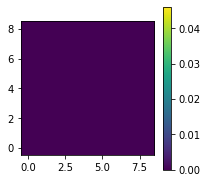


Percent Error at x node 1


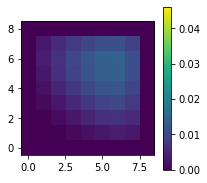


Percent Error at x node 2


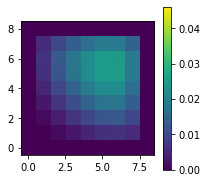


Percent Error at x node 3


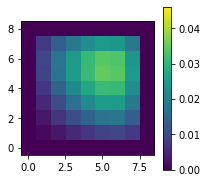


Percent Error at x node 4


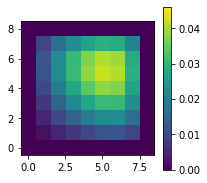


Percent Error at x node 5


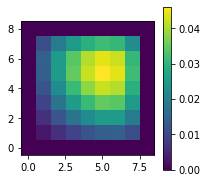


Percent Error at x node 6


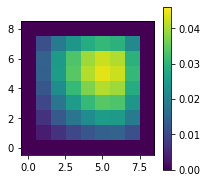


Percent Error at x node 7


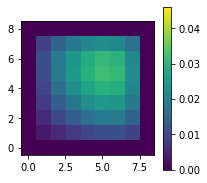


Percent Error at x node 8


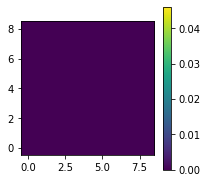

In [33]:
error = (next-U(25))*100/U(25)   #percent error = 100*(final solution at t=.25 - exact solution) /exact solution
print(np.linalg.norm(error)) #print norm of error

for i in range(0,9):        #plot error at all 9 xnodes for visualization
  print("Percent Error at x node "+str(i))
  plt.imshow(error[i])        #plot error
  plt.colorbar()
  plt.clim(0, np.max(error)) 
  plt.gca().invert_yaxis()
  plt.show()
  print()
